<a href="https://www.kaggle.com/code/clemwo/sales-eda-a-b-testing-predictive-modeling?scriptVersionId=194482137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter, FuncFormatter

sns.set(style="white")

/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv


<img src="https://seismic.com/wp-content/uploads/2014/09/3-Ways-to-Improve-Sales-Synergy.png" alt="Sales Image" width="800"/>

# 💹 Sales 🤖 EDA, A/B Testing & Predictive Modeling

> In this notebook we are going to work with [Kaggles Clicks Conversion Tracking dataset](https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking/data) which contains data from an anonymous organisation’s social media ad campaign. The objective of this notebook is to perform
>
> - 📊✨ informative and nicely-looking descriptive analysis and EDA
> 
> - 💹🔍 conversion rate, segment, cost efficiency and campaign performance analysis 
> 
> - 🔄🧪 A/B testing 
> 
> - 🤖📈 predictive modeling

In [2]:
sales = pd.read_csv('/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv')
print(f"Rows: {sales.shape[0]:,}")
print(f"Cols: {sales.shape[1]:,}")
print(sales.dtypes)
sales.head(3)

Rows: 1,143
Cols: 11
ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0


The columns are described as follows: 

| Column              | Description                                                                                              |
|:--------------------|:---------------------------------------------------------------------------------------------------------|
| `ad_id`               | A unique ID for each ad.                                                                                 |
| `xyz_campaign_id`     | An ID associated with each ad campaign of XYZ company.                                                   |
| `fb_campaign_id`      | An ID associated with how Facebook tracks each campaign.                                                 |
| `age`                 | Age of the person to whom the ad is shown.                                                               |
| `gender`              | Gender of the person to whom the ad is shown.                                                            |
| `interest`            | A code specifying the category to which the person’s interest belongs (as mentioned in the person’s Facebook public profile). |
| `Impressions`         | The number of times the ad was shown.                                                                    |
| `Clicks`              | Number of clicks on that ad.                                                                             |
| `Spent`               | Amount paid by company XYZ to Facebook to show that ad.                                                  |
| `Total conversion`    | Total number of people who enquired about the product after seeing the ad.                               |
| `Approved conversion` | Total number of people who bought the product after seeing the ad.                                       |


# Descriptive Analysis

In this section we are going to take a look at some summary statistics for the numerical variables. Additionally we are going to investigate the cardinalities of the categorical columnns.

In [3]:
# --- Basic statistics ---
pd.DataFrame(
    {
        'Data Type': sales.dtypes,
        'Missing Count (#)': sales.isnull().sum(),
        'Missing Rate (%)': 100 * sales.isnull().mean(),
        'Unique Count (#)': sales.nunique(),
        'Unique Rate (%)': round(100 * sales.nunique() / sales.shape[0], 2),
        'Duplicates Count (#)': [sales[c].duplicated().sum() for c in sales.columns],
        'Duplicates Rate (%)': [round(100 * sales[c].duplicated().sum() / sales.shape[0], 2) for c in sales.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
ad_id,int64,0,0.0,1143,100.00,0,0.00
xyz_campaign_id,int64,0,0.0,3,0.26,1140,99.74
fb_campaign_id,int64,0,0.0,691,60.45,452,39.55
age,object,0,0.0,4,0.35,1139,99.65
gender,object,0,0.0,2,0.17,1141,99.83
interest,int64,0,0.0,40,3.50,1103,96.50
Impressions,int64,0,0.0,1130,98.86,13,1.14
Clicks,int64,0,0.0,183,16.01,960,83.99
Spent,float64,0,0.0,869,76.03,274,23.97
Total_Conversion,int64,0,0.0,32,2.80,1111,97.20


- There are no missing values in the dataset 😊. 
- The dataset contains data of __1143 adds__.
- There are only __3 xyz campaigns__ in the dataset.
- There are __691 Facebook campaigns__ in the dataset.
- The customers are segmented into 4 age buckets.

## Numerical Variables

In [4]:
sales_numericals = sales.select_dtypes(include=['int64', 'float64'])

sales_numericals.describe().apply(lambda s: s.apply(lambda x: f"{x:,.2f}"))

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,"1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00"
mean,"987,261.13","1,067.38","133,783.99",32.77,"186,732.13",33.39,51.36,2.86,0.94
std,"193,992.81",121.63,"20,500.31",26.95,"312,762.18",56.89,86.91,4.48,1.74
min,"708,746.00",916.00,"103,916.00",2.00,87.00,0.00,0.00,0.00,0.00
25%,"777,632.50",936.00,"115,716.00",16.00,"6,503.50",1.00,1.48,1.00,0.00
50%,"1,121,185.00","1,178.00","144,549.00",25.00,"51,509.00",8.00,12.37,1.00,1.00
75%,"1,121,804.50","1,178.00","144,657.50",31.00,"221,769.00",37.50,60.02,3.00,1.00
max,"1,314,415.00","1,178.00","179,982.00",114.00,"3,052,003.00",421.00,639.95,60.00,21.00


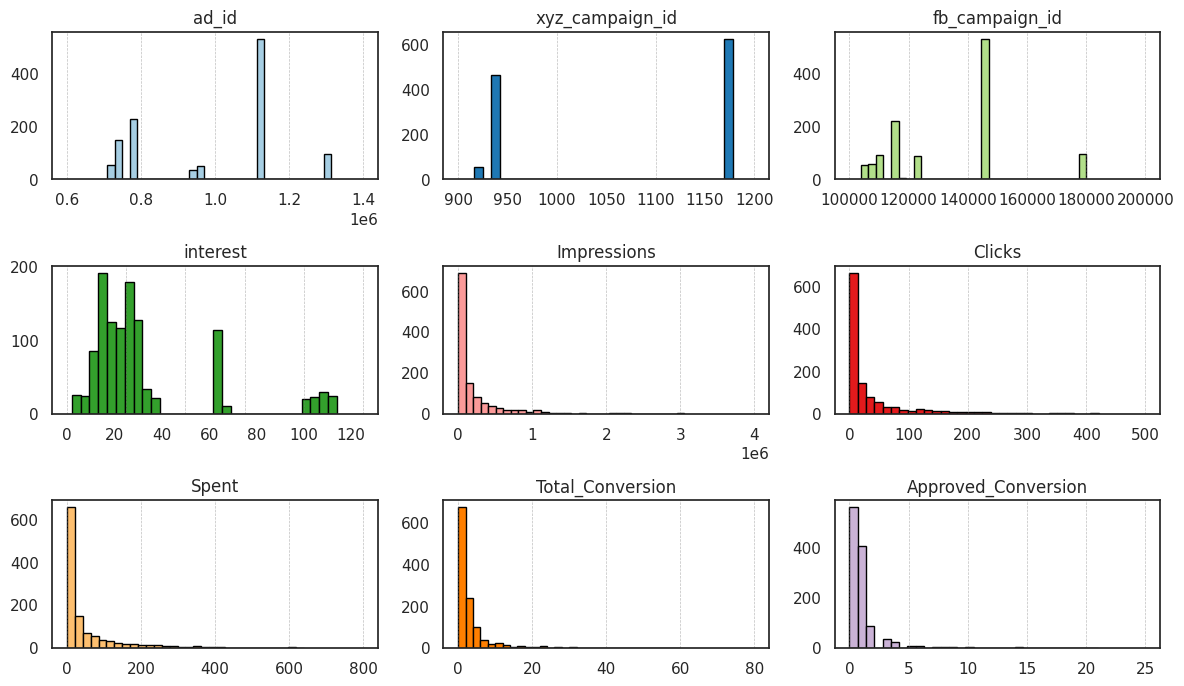

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate(sales_numericals):
    ax = axes[i]
    ax.hist(sales[col].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    
    
    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)       

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

## Categorical Variables

In [6]:
sales_categoricals = sales.select_dtypes(exclude=['int64', 'float64'])

sales_categoricals.value_counts()

age    gender
30-34  M         229
       F         197
35-39  M         139
45-49  F         138
       M         121
35-39  F         109
40-44  F         107
       M         103
Name: count, dtype: int64

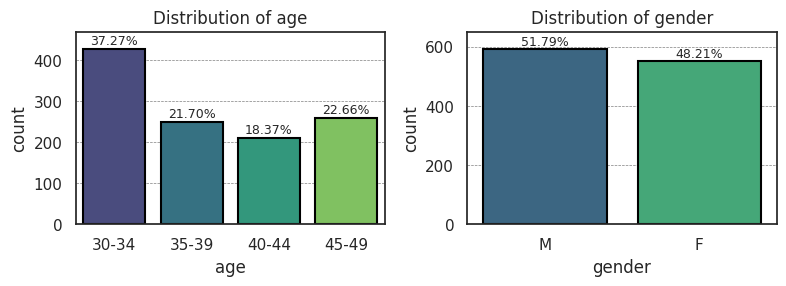

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

for i, col in enumerate(sales_categoricals):
    ax = axes[i]
    
    plot = sns.countplot(data=sales, x=col, 
                         palette='viridis', edgecolor='black', linewidth=1.5, 
                         ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)    
    
    # Add percentage at the top of each bar.
    total = len(sales[col])
    max_height = 0
    for p in plot.patches:
        height = p.get_height()
        max_height = max(max_height, height)
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 12, 
                f'{percentage:.2f}%', ha='center', fontsize=9)

    ax.set_ylim(0, max_height * 1.10)
    

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

# Exploratory Data Analysis (EDA)

# Conversion Rate Analysis

Let's first clarify some definitions: 

$$
\begin{align}
    \text{Click-Through Rate}        &= CTR &&= \frac{\text{Clicks}}{\text{Impressions}} \times 100\%         \quad &\text{Percentage of impressions that resulted in clicks} \\
    \text{Total Conversion Rate}     &= CR  &&= \frac{\text{Total_Conversion}}{\text{Clicks}} \times 100\%    \quad &\text{Percentage of clicks that resulted in any conversion} \\
    \text{Approved Conversion Rate}  &=     &&= \frac{\text{Approved_Conversion}}{\text{Clicks}} \times 100\% \quad &\text{Percentage of clicks that resulted in approved conversions}\\    
    \text{Cost Per Click}            &= CPC &&= \frac{\text{Spent}}{\text{Clicks}}                            \quad &\text{Cost efficiency per click}\\    
    \text{Cost Per Conversion}       &=     &&= \frac{\text{Spent}}{\text{Total_Conversion}}                  \quad &\text{Cost efficiency per conversion}
\end{align}
$$

In [8]:
sales['Click_Through_Rate']       = (sales['Clicks'] / sales['Impressions']) * 100
sales['Total_Conversion_Rate']    = (sales['Total_Conversion'] / sales['Clicks']) * 100
sales['Approved_Conversion_Rate'] = (sales['Approved_Conversion'] / sales['Clicks']) * 100
sales['Cost_Per_Click']           = sales['Spent'] / sales['Clicks']                 
sales['Cost_Per_Conversion']      = sales['Spent'] / sales['Total_Conversion'] 

conversion_columns = [
    'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate',
    'Cost_Per_Click', 'Cost_Per_Conversion'
]

sales.head(5)

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.013605,200.0,100.0,1.43,0.715
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.011198,100.0,0.0,0.91,0.910
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,inf,NaN,NaN,0.000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.023480,100.0,0.0,1.25,1.250
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.024195,100.0,100.0,1.29,1.290


Note that above `1/0=inf` and `0/0=NaN`.

Before we start analysing our data we should be aware of the following: 

- _High CTR_: Indicates that the ad is successful in getting people to click on it.
- _Total Conversion Rate_: Shows the overall effectiveness of turning clicks into any form of conversion.
- _Approved Conversion Rate_: Specifically focuses on conversions that were approved, which might be more critical depending on the campaign goals.
- _CPC and Cost Per Conversion_: Lower values are generally better, indicating cost efficiency in acquiring clicks and conversions.

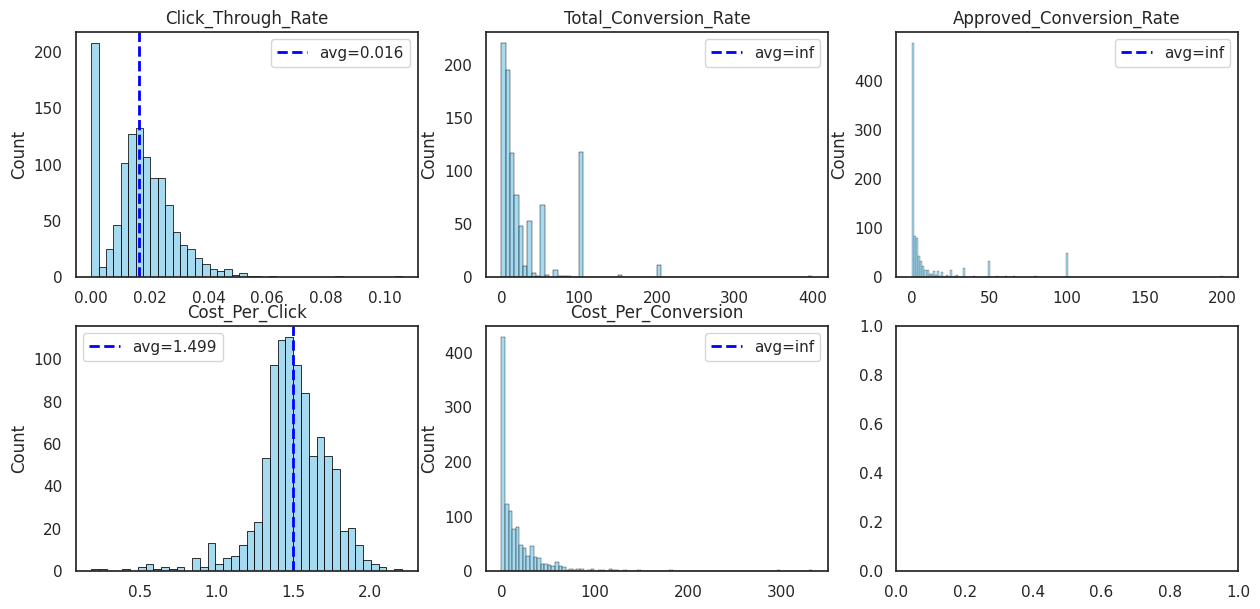

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(conversion_columns):
    sns.histplot(sales, x=col, 
                 color='skyblue', edgecolor='black', ax=axes[i]);
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = sales[col].mean()
    axes[i].axvline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
plt.show()

__Click Through Rate__ (CTR)
- Let's keep in mind that the higher the CTR the better, because then the rate of impressions that resulted in clicks is high.
- The average CTR is are 0.016%. This means that, __on average, 1 click is generated for every 6,250 impressions__. (because 0.016 out of 100 impressions result in a click, and thus, $1/0.00016 \approx 6250$ is how many impressions are needed for 1 click)
- More than 200 ads have a CTR of 0% which indicates that no click at all has been made.

__Total Conversion Rate__ (TCR)
- The distribution is largely left skewed.
- The average TCR is inf. This indicates that, __on average no click resulted in any enquiry (conversion)__.
- There are some adds with have a TCR above 100, which means that the `Total number of people who enquired about the product after seeing the ad` is higher than the `number of people who clicked on that ad`. That can be because a single person who clicked can enquiry more than 1 person. 
- It looks like the maximal TCR is around 400. This indicates that __at least for one ad 4 times more people enquiried the ad compared to clicking on it__.

__Approved Conversion Rate__ (ACR)
- The distribution is even more extremely left skewed than the one of the TCR.
- __Most of the time, no person bought the ad after seeing it__. 

__Cost Per Click__
- The distribution has Gaussian shape.
- On average the cost per click is 1.5.
- The cost per click doesn't fluctuate strongly around the mean.
- The maximal cost per click lies below 2.5. 

__Cost Per Conversion__
- The distribution is highly left skewed.
- At least one ad costs more than 300 for a conversion.

__Summary__

The most interesting findings are: 

> - It takes on average 6,250 impressions to generate a click on an add.
> 
> - On average no click resulted in any conversion.
> 
> - On average a click costs 1.5. It never costs above 2.5.
> 
> - At least one ad costs more than 300 for a conversion.

# Segment Analysis

# Cost Efficiency Analysis

# Campaign Performance Analysis

# A/B Testing Analysis

# Predictive Modeling

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏